# Detección de Reseñas Negativas en Películas Clásicas

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

Aquí se describen los campos seleccionados:

- `review`: Texto de la reseña.
- `pos`: Objetivo ('0' para negativo y '1' para positivo).
- `ds_part`: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente.

## Inicialización

In [410]:
# Carga todas las librerías

# Manipulación de datos
import math
import re
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Modelado
import torch
import transformers
import spacy
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.metrics as metrics

In [411]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# La siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

/var/folders/jf/sq6w1w1x7v9bvtbslbdtrlb00000gn/T/ipykernel_82118/3190433826.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [412]:
# Esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

In [413]:
# Esto es para descargar las stopwords de NLTK 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/keneth4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [414]:
# Esto es para descargar el modelo de spacy
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Cargar los datos

In [415]:
# Carga los datos en DataFrames
try:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except Exception:
    df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Preparación de datos

In [416]:
# Imprime la información general/resumen sobre el DataFrame
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [417]:
# Imprime una muestra aleatoria de 5 filas del DataFrame
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
5525,tt0403118,tvMovie,Brave New Girl,Brave New Girl,2004,\N,120,0,"Drama,Family,Music",5.0,804,"Being a music student myself, I thought a movi...",1,neg,0,train,1668
24357,tt0087805,movie,Ninja III: The Domination,Ninja III: The Domination,1984,\N,92,0,"Action,Fantasy,Thriller",5.4,3745,There are few movies that have the massive amo...,10,pos,1,test,10693
3364,tt0230011,movie,Atlantis: The Lost Empire,Atlantis: The Lost Empire,2001,\N,95,0,"Action,Adventure,Animation",6.9,100274,I LOVED this movie! I am biased seeing as I am...,10,pos,1,train,6369
27537,tt0045064,movie,Radar Men from the Moon,Radar Men from the Moon,1952,\N,167,0,"Action,Sci-Fi",4.7,779,"Oh, man, how low serials had fallen as by 1952...",2,neg,0,train,9394
4176,tt0044404,short,"Beep, Beep","Beep, Beep",1952,\N,7,0,"Animation,Comedy,Family",7.8,1343,Chuck Jones's 'Beep Beep' (so called despite t...,7,pos,1,test,4868


### Conclusión intermedia

A pesar de que ninguna de las columnas contiene valores ausentes, el tipo de dato en algunas de ellas indica que en realidad si podría haber datos ausentes representados por valores tipo `string`. Será necesario realizar un análisis exploratorio con enfoque en las columnas elegidas para determinar si dichos valores se encuentran en estas columnas.

## EDA

### Número de películas y reseñas a lo largo de los años

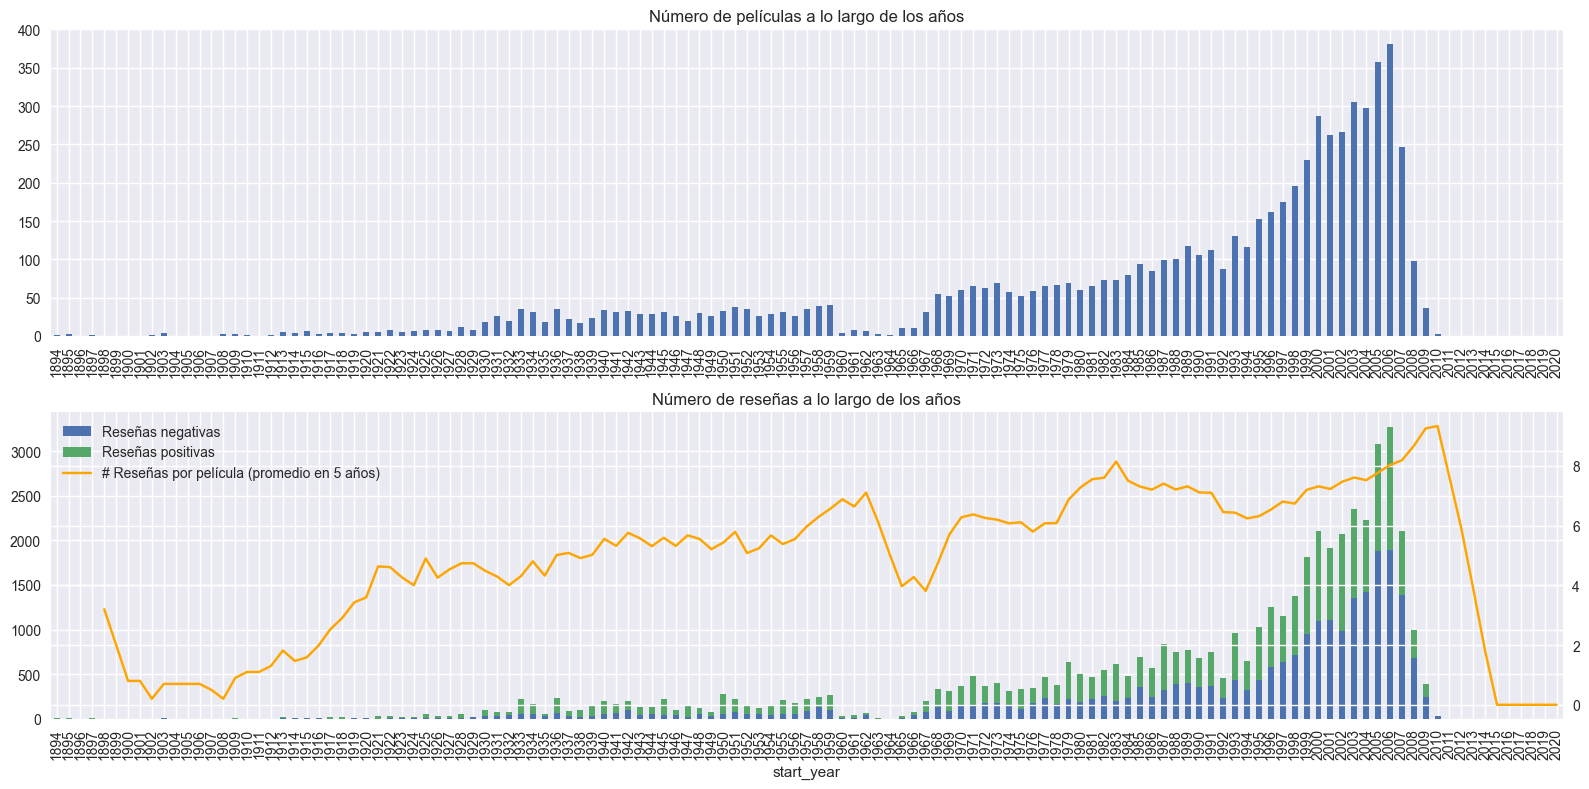

In [418]:
# Crear gráficos de barras para el número de películas y reseñas a lo largo de los años
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]
# Gráfico de barras para el número de películas a lo largo de los años
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]
# Gráfico de barras para el número de reseñas positivas y negativas a lo largo de los años
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0).rename(columns={0: 'Reseñas negativas', 1: 'Reseñas positivas'})
dft2.plot(kind='bar', stacked=True, ax=ax)
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# Gráfico de línea para el número de reseñas por película a lo largo de los años (promedio en 5 años)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='# Reseñas por película (promedio en 5 años)', ax=axt)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
lines, labels = lines1 + lines2, labels1 + labels2
ax.legend(lines, labels, loc='upper left')
ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

### Distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

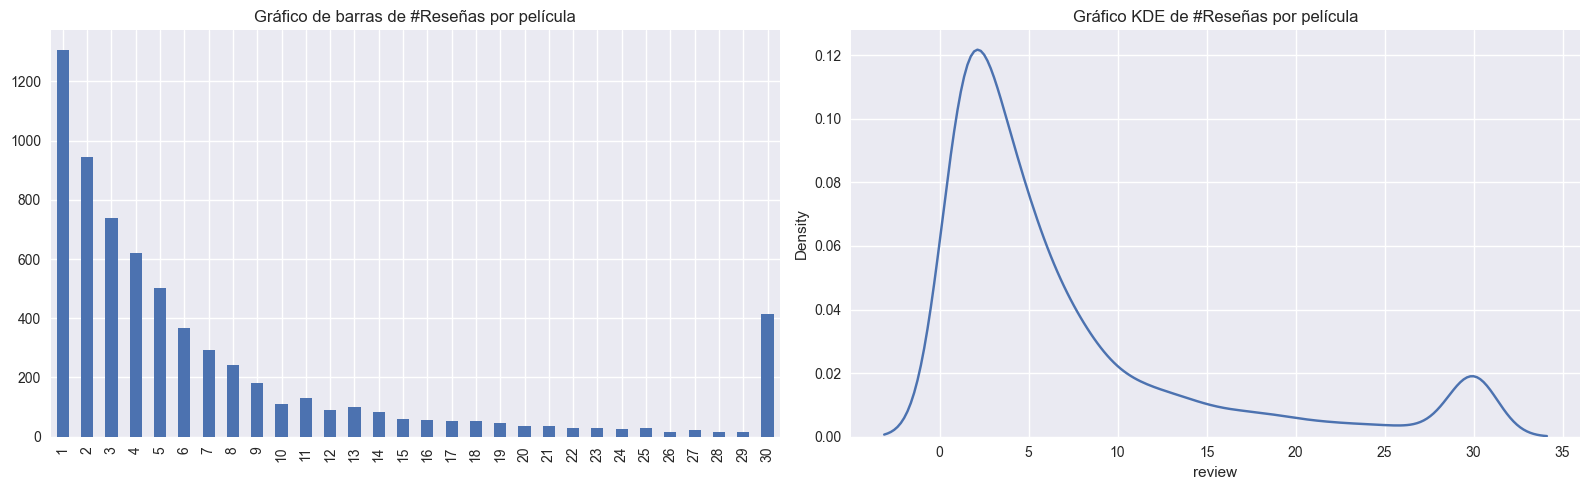

In [419]:
# Crear un gráfico de barras y KDE para el número de reseñas por película
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

### Distribución de puntuaciones en los conjuntos de entrenamiento y prueba

In [420]:
# Mostrar los diferentes valores de la columna 'ds_part'
df_reviews['ds_part'].value_counts()

train    23796
test     23535
Name: ds_part, dtype: int64

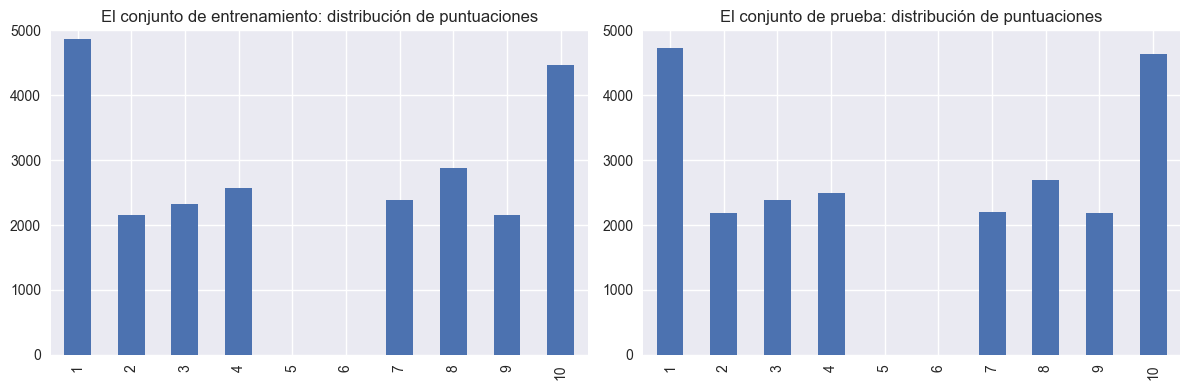

In [421]:
# Crear gráficos de barras para la distribución de puntuaciones en los conjuntos de entrenamiento y prueba
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

### Distribución de reseñas de diferentes polaridades por año y película en los conjuntos de entrenamiento y prueba

In [422]:
# Mostrar los diferentes valores de la columna 'pos'
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

### Conclusión intermedia

- El número de películas a través de los años tiene un notable incremento, mientras que el número de reseñas sólo incrementó un poco.
- El número de reseñas por película varía muchísimo dependiendo de ésta.
- Las puntuaciones tienen una tendencia de polarización, ya que la distribución es mayor en los valores de las orillas.

Para las tres columnas elegidas (`review`, `pos`, `ds_part`):
- Parece no haber ningún problema de valores ausentes.
- El tipo de dato es el correcto.
- La distribución de polaridades en los diferentes conjuntos de datos es muy similar.

## Procedimiento de evaluación

In [423]:
# Crear función para evaluar los diferentes modelos
def evaluate_model(model, train_features, train_target, test_features, test_target):
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [424]:
# Crear función para normalizar el texto
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [425]:
# Aplicar la función de normalización de texto a la columna 'review'
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

In [426]:
# Mostrar el resultado de la normalización de texto
df_reviews[['review', 'review_norm']].sample(5)

,review,review_norm
7771,Don't hate Heather Graham because she's beauti...,don t hate heather graham because she s beauti...
29189,Royal Rumble 1988 bored me pretty damn good. T...,royal rumble bored me pretty damn good the rum...
40166,"I didn't really expect much from ""The Night Li...",i didn t really expect much from the night lis...
7128,Makes the fourth theatrical release (the one N...,makes the fourth theatrical release the one na...
13696,Watching Marlen Brando on screen is like watch...,watching marlen brando on screen is like watch...


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [427]:
# Dividir el conjunto de datos en entrenamiento y prueba
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [428]:
# Obtener una muestra de los conjuntos de entrenamiento y prueba para reducir el tiempo de entrenamiento
sample_size = 3000
df_reviews_train_sample = df_reviews_train.sample(sample_size, random_state=12345).copy()
df_reviews_test_sample = df_reviews_test.sample(sample_size, random_state=12345).copy()

In [429]:
# Obtener el conjunto de objetivos
train_target = df_reviews_train_sample['pos']
test_target = df_reviews_test_sample['pos']

## Trabajar con modelos

### Modelo 0 - Constante

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


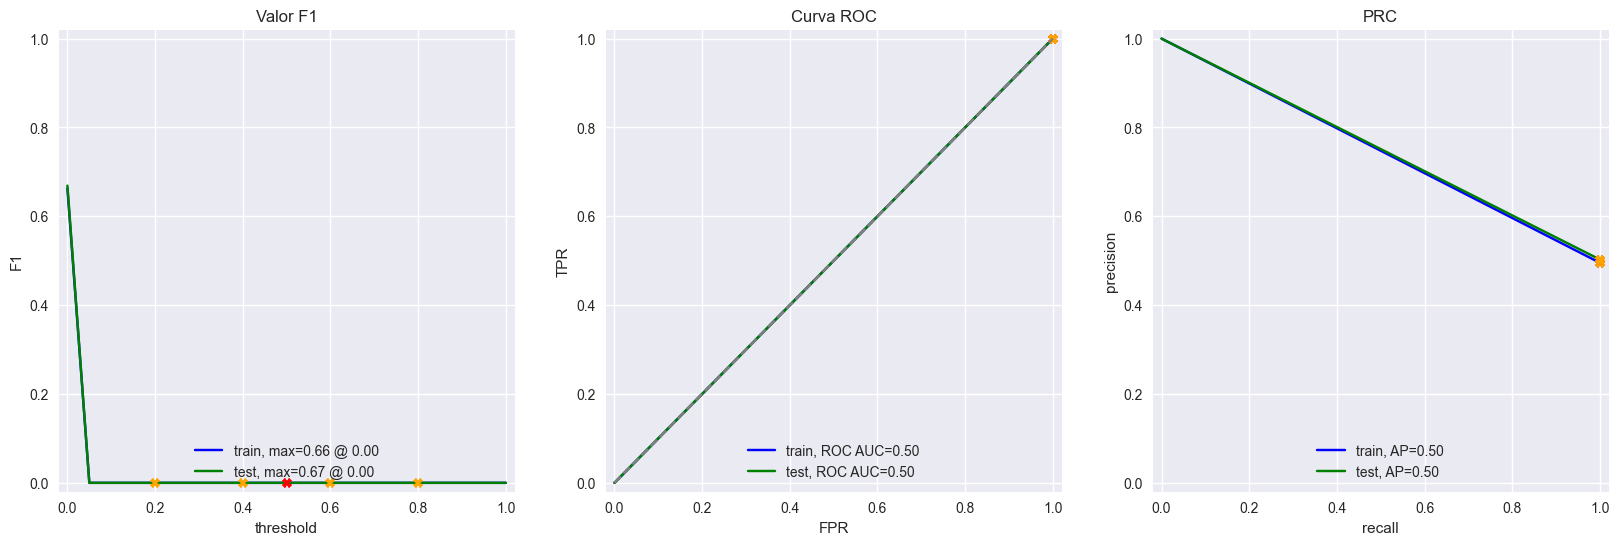

In [430]:
# Obtener el conjunto de características
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform(df_reviews_train_sample['review_norm'])
test_features = vectorizer.transform(df_reviews_test_sample['review_norm'])

# DummyClassifier
dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy.fit(train_features, train_target)

# Evaluar el modelo
evaluate_model(dummy, train_features, train_target, test_features, test_target)

### Modelo 1 - NLTK, TF-IDF y LR

          train  test
Accuracy   0.96  0.84
F1         0.96  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


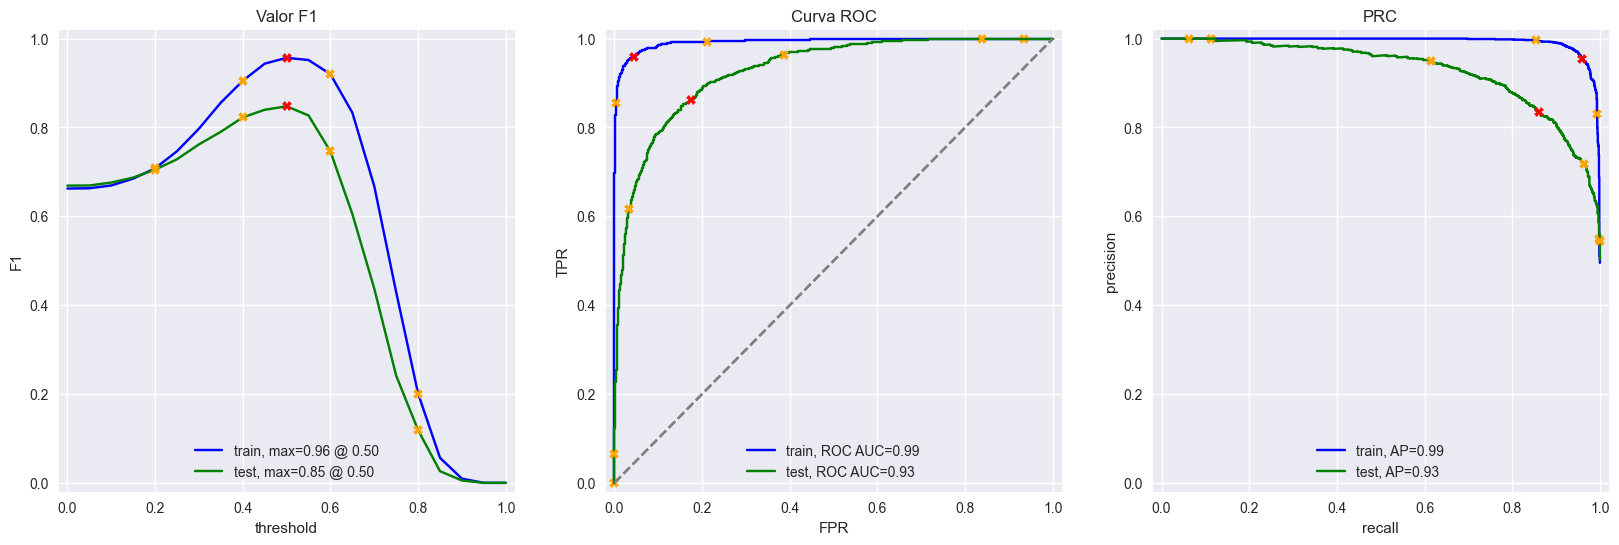

In [431]:
# Obtener el conjunto de características
count_tf_idf_1 = TfidfVectorizer(stop_words=list(set(nltk_stopwords.words('english'))))
count_tf_idf_1.fit(df_reviews_train['review_norm'])
train_features = count_tf_idf_1.transform(df_reviews_train_sample['review_norm'])
test_features = count_tf_idf_1.transform(df_reviews_test_sample['review_norm'])

# LogisticRegression
logreg_1 = LogisticRegression(random_state=12345)
logreg_1.fit(train_features, train_target)

# Evaluar el modelo
evaluate_model(logreg_1, train_features, train_target, test_features, test_target)

### Modelo 2 - spaCy, TF-IDF y LR

In [432]:
# Crear instancia de Spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Crear función para lematizar el texto
def lemmatize(text):
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

In [433]:
# Aplicar la función de lematización de texto a la columna 'review_norm'
df_reviews_train_sample['review_lemma'] = df_reviews_train_sample['review_norm'].apply(lemmatize)
df_reviews_test_sample['review_lemma'] = df_reviews_test_sample['review_norm'].apply(lemmatize)

# Mostrar el resultado de la lematización de texto
df_reviews_train_sample[['review', 'review_norm', 'review_lemma']].head(5)

,review,review_norm,review_lemma
14148,Who? What? Where? When? Why? The acting was te...,who what where when why the acting was terribl...,who what where when why the acting be terrible...
40229,THE NOTORIOUS BETTIE PAGE Written by Mary Harr...,the notorious bettie page written by mary harr...,the notorious bettie page write by mary harron...
38690,It is not as great a film as many people belie...,it is not as great a film as many people belie...,it be not as great a film as many people belie...
13231,When I saw this trailer on TV I was surprised....,when i saw this trailer on tv i was surprised ...,when I see this trailer on tv I be surprised i...
28023,"As others have commented, I checked this out a...",as others have commented i checked this out af...,as other have comment I check this out after s...


          train  test
Accuracy   0.95  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


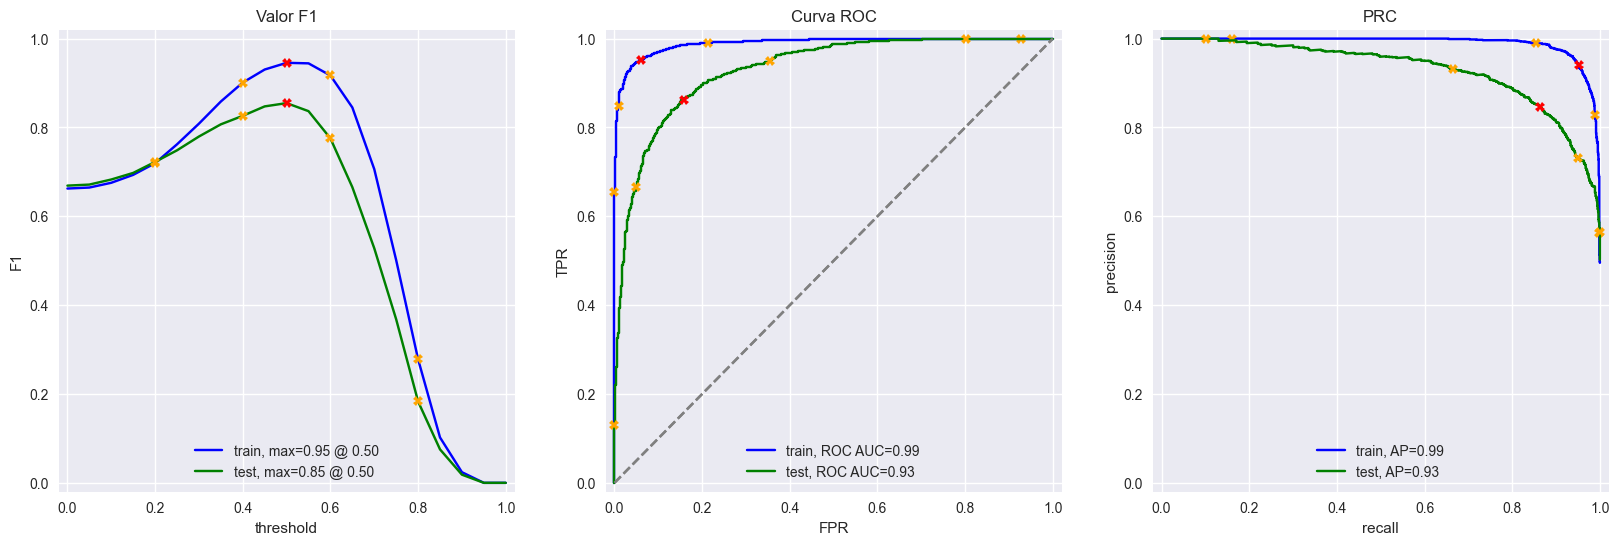

In [434]:
# Obtener el conjunto de características
count_tf_idf_2 = TfidfVectorizer(stop_words=list(set(nltk_stopwords.words('english'))))
count_tf_idf_2.fit(df_reviews_train_sample['review_lemma'])
train_features_lemma = count_tf_idf_2.transform(df_reviews_train_sample['review_lemma'])
test_features_lemma = count_tf_idf_2.transform(df_reviews_test_sample['review_lemma'])

# LogisticRegression
logreg_2 = LogisticRegression(random_state=12345)
logreg_2.fit(train_features_lemma, train_target)

# Evaluar el modelo
evaluate_model(logreg_2, train_features_lemma, train_target, test_features_lemma, test_target)

### Modelo 3 - BERT

In [435]:
# Inicializar el tokenizador, el modelo y la configuración de BERT
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [436]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    # texto al id de relleno de tokens junto con sus máscaras de atención 
    ids_list = []
    attention_mask_list = []

    tokenized_texts = texts.apply(
        lambda x: 
        tokenizer.encode(
            x.lower(),
            add_special_tokens=True,
            truncation=True,
            max_length=max_length
        )
    )
    
    for ids in tokenized_texts:
        padded = np.array(ids[:max_length] + [0]*(max_length - len(ids)))
        ids_list.append(padded)
        attention_mask_list.append(np.where(padded != 0, 1, 0))
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)])
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [437]:
# Obtener el conjunto de características
# train_features_bert = BERT_text_to_embeddings(df_reviews_train_sample['review_norm'])
# test_features_bert = BERT_text_to_embeddings(df_reviews_test_sample['review_norm'])

In [438]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_bert.npz', train_features_bert=train_features_bert, test_features_bert=test_features_bert)

# y cargar...
with np.load('features_bert.npz') as data:
    train_features_bert = data['train_features_bert']
    test_features_bert = data['test_features_bert']

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          train  test
Accuracy   0.91  0.82
F1         0.91  0.82
APS        0.97  0.90
ROC AUC    0.97  0.90


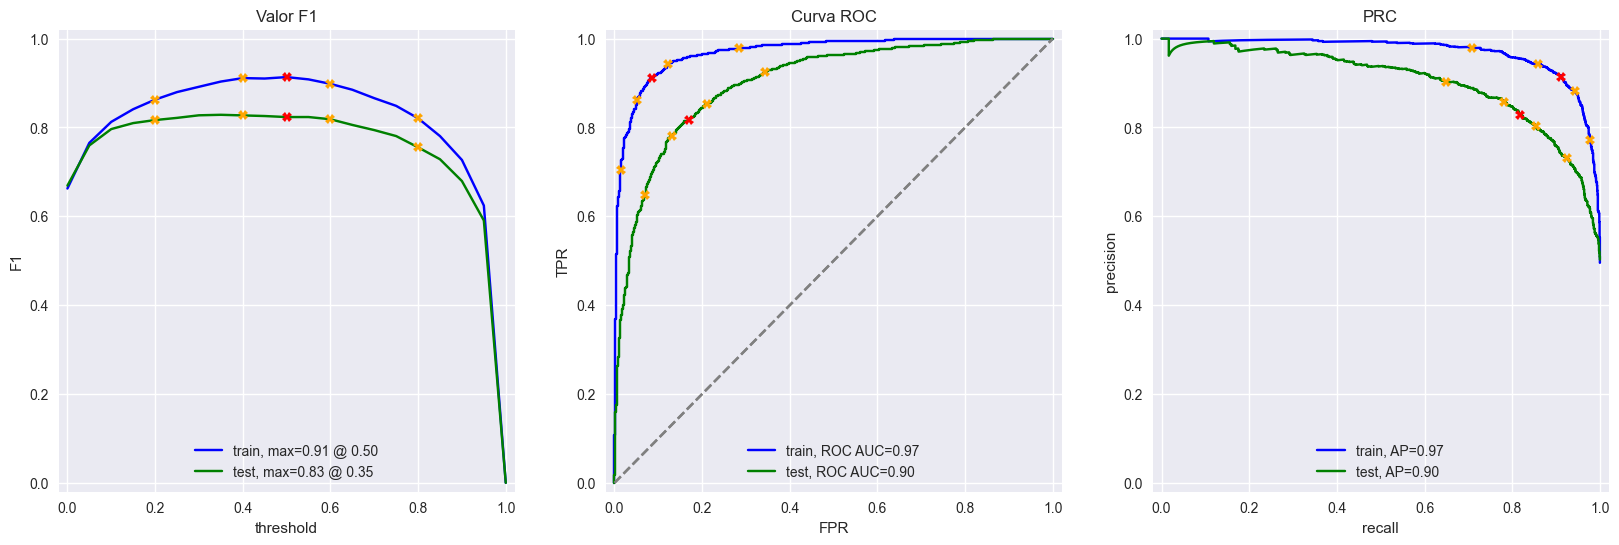

In [439]:
# LogisticRegression
logreg_3 = LogisticRegression(random_state=12345)
logreg_3.fit(train_features_bert, train_target)

# Evaluar el modelo
evaluate_model(logreg_3, train_features_bert, train_target, test_features_bert, test_target)

### Conclusión intermedia

- `Modelo 0 - Constante`: Actúa como base, siempre predice igual y tiene un F1 de 0. Sus Accuracy, APS y ROC AUC son de 0.5, indicando predicciones aleatorias.

- `Modelo 1 - NLTK, TF-IDF y LR`: Este modelo ofrece un rendimiento bastante similar al del Modelo 2. Con puntuaciones cercanas al 0.9 en pruebas, la combinación de NLTK, TF-IDF y regresión logística produce un modelo robusto.

- `Modelo 2 - spaCy, TF-IDF y LR`: Rendimiento practicamente idéntico al Modelo 1, esto sugiere que tanto NLTK como spaCy, al ser usados con TF-IDF y regresión logística, tienen capacidades similares en este contexto.

- `Modelo 3 - BERT`: Si bien aún se encuentra ligeramente detrás de los modelos 1 y 2 en pruebas, su capacidad para capturar contextos complejos destaca. Con más optimización, BERT podría ofrecer un rendimiento aún mejor.


## Mis reseñas

In [440]:
# Crear un conjunto de reseñas de películas para probar los modelos
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Normalizar el texto
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

# Mostrar el resultado de la normalización de texto
my_reviews[['review', 'review_norm']].sample(5)

# Guardar el texto normalizado para usarlo más tarde
texts = my_reviews['review_norm']

### Test Modelo 0 - Constante

In [441]:
# Obtener predicciones con el modelo Dummy
my_reviews_pred_prob = dummy.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
0.00:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.00:  i didn t expect the reboot to be so good writers really cared about the source material
0.00:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.00:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.00:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Test Modelo 1 - NLTK, TF-IDF y LR

In [442]:
# Obtener predicciones con el modelo 1 - NLTK, TF-IDF y LR
my_reviews_pred_prob = logreg_1.predict_proba(count_tf_idf_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.30:  i did not simply like it not my kind of movie
0.43:  well i was bored and felt asleep in the middle of the movie
0.43:  i was really fascinated with the movie
0.33:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.47:  i didn t expect the reboot to be so good writers really cared about the source material
0.44:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.33:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.68:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Test Modelo 2 - spaCy, TF-IDF y LR

In [443]:
# Obtener predicciones con el modelo 2 - spaCy, TF-IDF y LR
my_reviews_pred_prob = logreg_2.predict_proba(count_tf_idf_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.35:  i did not simply like it not my kind of movie
0.47:  well i was bored and felt asleep in the middle of the movie
0.46:  i was really fascinated with the movie
0.38:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.51:  i didn t expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.32:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.79:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Test Modelo 3 - BERT

In [444]:
# Obtener predicciones con el modelo 3 - BERT

my_reviews_features_bert = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = logreg_3.predict_proba(my_reviews_features_bert)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.47:  i did not simply like it not my kind of movie
0.00:  well i was bored and felt asleep in the middle of the movie
0.89:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.46:  i didn t expect the reboot to be so good writers really cared about the source material
0.91:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.98:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Conclusión intermedia

Dejando de lado los resultados del modelo Dummy, existe una similitud muy grande entre los modelos 1 y 2, ambos modelos, en términos generales, están en la misma línea de clasificación, pero con matices en su nivel de confianza. El Modelo 2 tiende a ser un poco más optimista en su clasificación, lo que puede ser útil o problemático dependiendo de la aplicación. Si se busca evitar falsos negativos (por ejemplo, en un contexto donde se quiera destacar la mayoría de los comentarios positivos), el Modelo 2 podría ser más adecuado. Por otro lado, si se prefiere ser más conservador y evitar falsos positivos, el Modelo 1 podría ser la mejor elección.

Hablando del modelo 3 (BERT), este demuestra su capacidad de capturar contextos complejos y matices en el lenguaje, ofreciendo una clasificación con una alta confianza en la mayoría de los casos. Las predicciones extremas (cercanas a 0 o 1) muestran la confianza del modelo en su decisión, mientras que las predicciones intermedias reflejan la ambigüedad o complejidad del texto. A pesar de su rendimiento, es esencial considerar el costo computacional asociado al uso de modelos como BERT, pero si se busca precisión y una comprensión profunda del contexto, BERT es una excelente elección.

# Conclusión General

A lo largo de este estudio sobre la clasificación de reseñas de películas:

1. Conducimos un análisis inicial de las reseñas, centrándonos en el sentimiento de cada una de ellas. Para facilitar el manejo, limitamos nuestro conjunto de datos a `3000` registros.

2. Desplegamos y comparamos diferentes técnicas de procesamiento de lenguaje natural (`NLTK, TF-IDF con LR`, `spaCy, TF-IDF con LR`, y `BERT`) con el objetivo de categorizar la polaridad de las reseñas de películas.

3. Incorporamos funciones avanzadas como embeddings y vectorizaciones.

4. Aunque los modelos NLTK y spaCy con TF-IDF y LR mostraron resultados similares en las pruebas, fue el modelo `BERT` el que resaltó por su capacidad para distinguir contextos y matices complejos en las reseñas, a pesar de un mayor costo computacional.

Con lo que se puede concluir que:

- `Modelo Dummy`: Como modelo base, siempre predijo la misma clase. Su F1 de 0 y APS y ROC AUC de 0.5 confirman que actúa simplemente como un generador de predicciones aleatorias y no aporta valor en términos de clasificación.

- `NLTK y spaCy con TF-IDF y LR`: Tanto el Modelo 1 como el Modelo 2 demostraron un rendimiento similar y robusto en la clasificación, con puntuaciones cercanas al 0.9 en pruebas. La similitud entre estos modelos indica que, para este conjunto de datos y contexto, `NLTK` y `spaCy` ofrecen capacidades equiparables cuando se combinan con `TF-IDF` y `regresión logística`. Sin embargo, es importante considerar sus matices: mientras el Modelo 1 tiende a ser más conservador en sus predicciones, el Modelo 2 muestra una inclinación ligeramente más optimista.

- `BERT`: El Modelo 3, ilustra la capacidad de los modelos de lenguaje profundo para capturar contextos complejos en las reseñas. `BERT` no solo brinda predicciones con alta confianza, sino que también refleja la ambigüedad inherente en algunos textos, podría incluso superar a otros modelos en términos de rendimiento.

Si bien los modelos convencionales (`NLTK` y `spaCy` con `TF-IDF` y `LR`) ofrecen una solución rápida y robusta para la clasificación, `BERT` emerge como una herramienta poderosa para quienes buscan un análisis más detallado y profundo de las reseñas, aunque a un costo computacional más alto. La elección final del modelo dependerá del equilibrio entre precisión, interpretación y eficiencia que se desee alcanzar.

**NOTA:** Vale la pena mencionar que a pesar de reducir el conjunto de datos a `3000` registros, el tiempo de procesamiento para la creación de los objetivos en el modelo 3 `BERT` tomó poco más de 40 minutos en una `cpu`.